## Домашнее задание

Рассмотрим граф $G=(V,E)$, вершинам которого случайным образом приписаны значения 0 и 1 так, что смежные вершины не могут одновременно иметь значение 1. Пример расстановки значений по вершинам графа показан на картинке ниже (черные вершины имеют значение 1, белые - 0):

![img](http://www.mathematik.uni-ulm.de/stochastik/lehre/ss06/markov/skript_engl/bild4.jpg)

Как оценить, сколько в среднем закрашенных вершин будет иметь такой граф?

Сформулируем задачу в математических терминах.

Пусть $\xi \in \{0,1\}^{V}$ обозначает конфигурацию графа (расстановку 0 и 1 по вершинам). Назовем конфигурацию допустимой, если вершины, соединенные ребрами, не имеют одновременно значения 1. Пусть $Z_G$ - общее количество допустимых конфигураций. Зададим  распределение на множестве всех конфигураций:
$$\begin{equation*}
\mu(\xi) = 
 \begin{cases}
   \frac{1}{Z_G}, &\text{$\xi$ - допустимая конфигурация}\\
   0, &\text{иначе.}
 \end{cases}
\end{equation*}$$
Обозначим $n(\xi)$ - число закрашенных вершин в конфигурации $\xi$. Тогда
$$
{\rm E} n(\xi) = \sum\limits_{x \in \{0,1\}^V} n(x) \mu(x) = \frac{1}{Z_G} \sum\limits_{x \in \{0,1\}^V} n(x) {\rm I}_{\{x - \text{допустимая} \}}
$$

Явно перебирать все $x \in \{0,1\}^{V}$ не представляется возможным. Мы могли бы попробовать оценить ${\rm E} n(\xi)$, используя закон больших чилел:
$$
{\rm E} n(\xi) \approx \frac{1}{N} \sum\limits_{i=1}^{N} n(\xi), \text{где $\xi \sim \mu$}
$$
Но есть проблема: как смоделировать случайную величину из распределения $\mu$?

В этом нам поможет метод MCMC.

## Задание

* Оценить  ${\rm E} n(\xi)$ с помощью МСМС для графа 8х8
* Обосновать численно и графически стационарность
* Построить график распределеиня $n(\xi)$

Вспомогательная функция для раскраски вершин графа в соответствии с переданной маской:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid(narr):
    '''Plots 2d lattice with vertices colored in black and red according to given mask.
    Vertice is colored black if narr[i, j] == True and red otherwise.
    
    Parameters
    ----------
    narr : 2d boolean ndarray
        Mask for vertices colors
    '''

    if narr.dtype != 'bool':
        raise ValueError('narr should be a boolean ndarray')
    colors = np.empty(narr.shape, dtype='U5')
    colors[:] = 'red'
    colors[narr] = 'black'
    x, y = np.indices((narr.shape))
    plt.scatter(x, y, c=colors.ravel())
    plt.show()

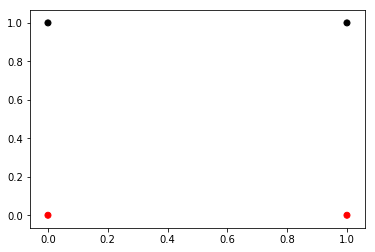

In [30]:
size = 2
narr = np.random.choice([0, 1], size=size**2).reshape((size, size))

plot_grid(narr.astype('bool'))

In [17]:
def metroplis(start, value, proposal, niter, nburn=0):
    '''Generic Metropolis scheme.
    Parameters
    ---
    start : misc
        Initial guess.
    value : callable
        Function to calculate density (unnormalized) at given point.
    proposal : callable
        Function to get suggestion on a new point based on a current one.
    niter : int
        Number of iterations.
    nburn : int
        Number of initial samples to be skipped.
    kwargs : dict
        Keywords to be passed in value and proposal.

    Return
    ---
    post : list
        List of samples obtained.
    '''
    current = start
    post = [value(current)]
    for i in range(niter):
        proposed = proposal(current)
        p = value(proposed) / (value(current)+1e-5)
        if np.random.rand() < p:
            current = proposed
        post.append(value(current))
    return post[nburn:]

In [18]:
value = lambda x: x.sum()##Считаем число закрашенных вершин
# Соседями считаем графы отличающиеся в одной точке
def proposal(X):##Выбераем граф для следующего шага из соседей
    s,_ = X.shape
    k = True
    while k:
        pos = np.random.choice(np.arange(0,s), size=2)##Выбераем положение в которой может отличатся сосед
        if X[pos[0]][pos[1]] == 1:
            X[pos[0]][pos[1]] = 0
            k = False
        else:
            if X[min(pos[0]+1,s-1)][pos[1]]+X[max(pos[0]-1,0)][pos[1]]+X[pos[0]][min(pos[1]+1,s-1)]+X[pos[0]][max(pos[1]-1,0)] == 0:
                X[pos[0]][pos[1]] = 1
                k = False
    return X

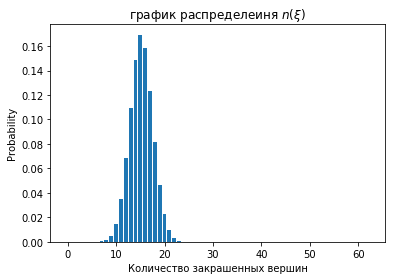

In [81]:
post = metroplis(np.zeros((8,8)), value, proposal, 100000)
# print(post)
# post = [value(np.array(i)) for i in post]

Probability,_,_ = plt.hist(post,bins=np.arange(0,64)-0.5 ,rwidth=0.8, density=True)
plt.xlabel('Количество закрашенных вершин')
plt.ylabel('Probability')
plt.title(r'график распределеиня $n(\xi)$')
plt.show()

In [85]:
Probability =  np.array(Probability)

Воспользуемся $\textbf{Законом Больших Чисел}$:

In [100]:
import random
niter = 10000
num = list(np.arange(0,63))
len(num)
S = 0.0
for i in range(niter):
    S += int(random.choices(num, weights =  Probability)[0])
S /=niter
print(f'Среднее значение закрашенных вершин графа: {S}')

Среднее значение закрашенных вершин графа: 15.1946


$\textbf{Gewerke test}$:


Разбиваем выборку на начальный и конечный куски $x_s$, $x_e$ и вычисляем статистику t-критерия Стьюдента.

In [54]:
from scipy import stats
def g_test(x, start=0.1, end=0.5):
    return stats.ttest_ind(x[:int(len(x) * start)], x[-int(len(x) * end):], equal_var=False)

$\textbf{Критерий Стьюдента}$:

$H_0$: Со временем процес достигает стационарного состояния

$H_1$: не верно

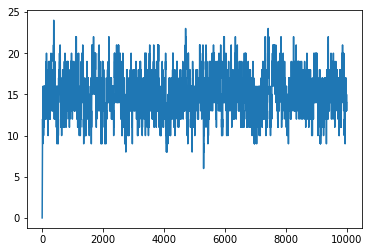

Ttest_indResult(statistic=-4.197991259819364, pvalue=2.8681729198049025e-05)

In [63]:
post = metroplis(np.zeros((8,8)), value, proposal, 10000)
plt.plot(post)
plt.show()

g_test(post)

In [64]:
g_test(post[1000:]) ## начиная с какого-то момента

Ttest_indResult(statistic=0.49414864971042055, pvalue=0.621292306300857)

$\textbf{Вывод: гипотезу стационарности не отвергаем}$